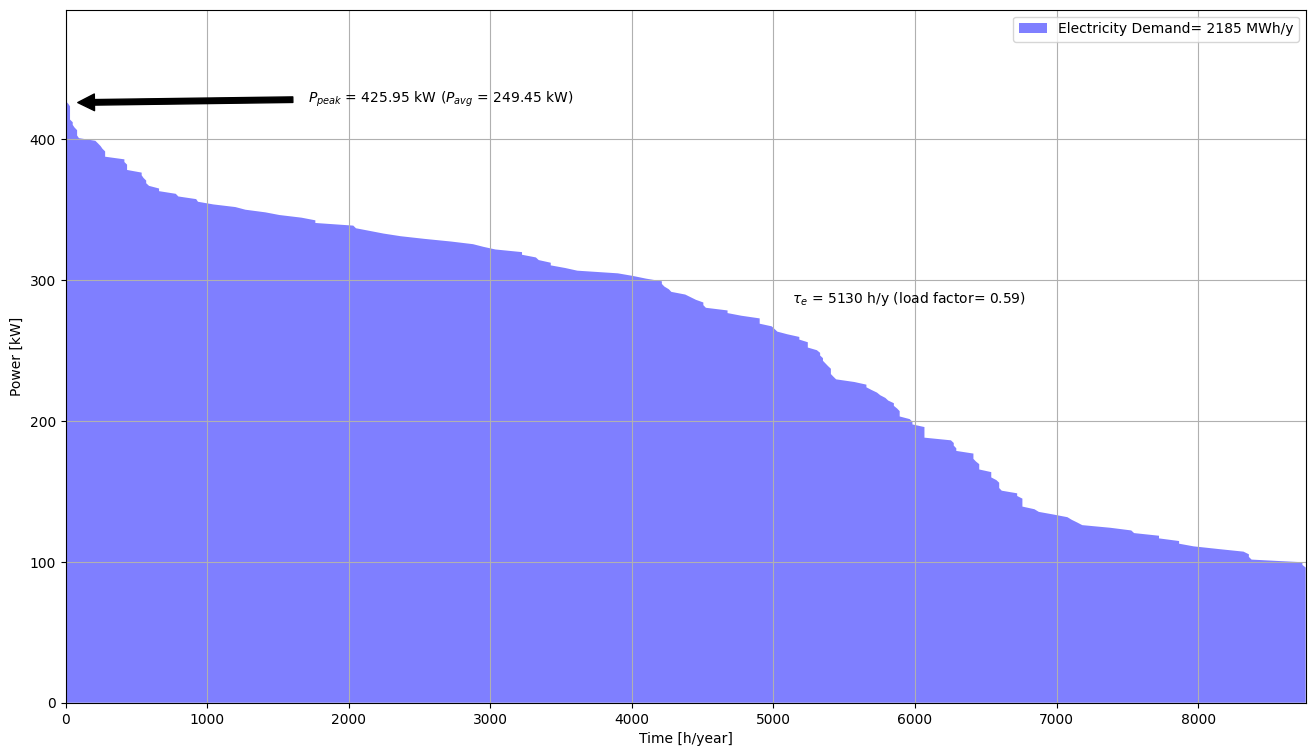

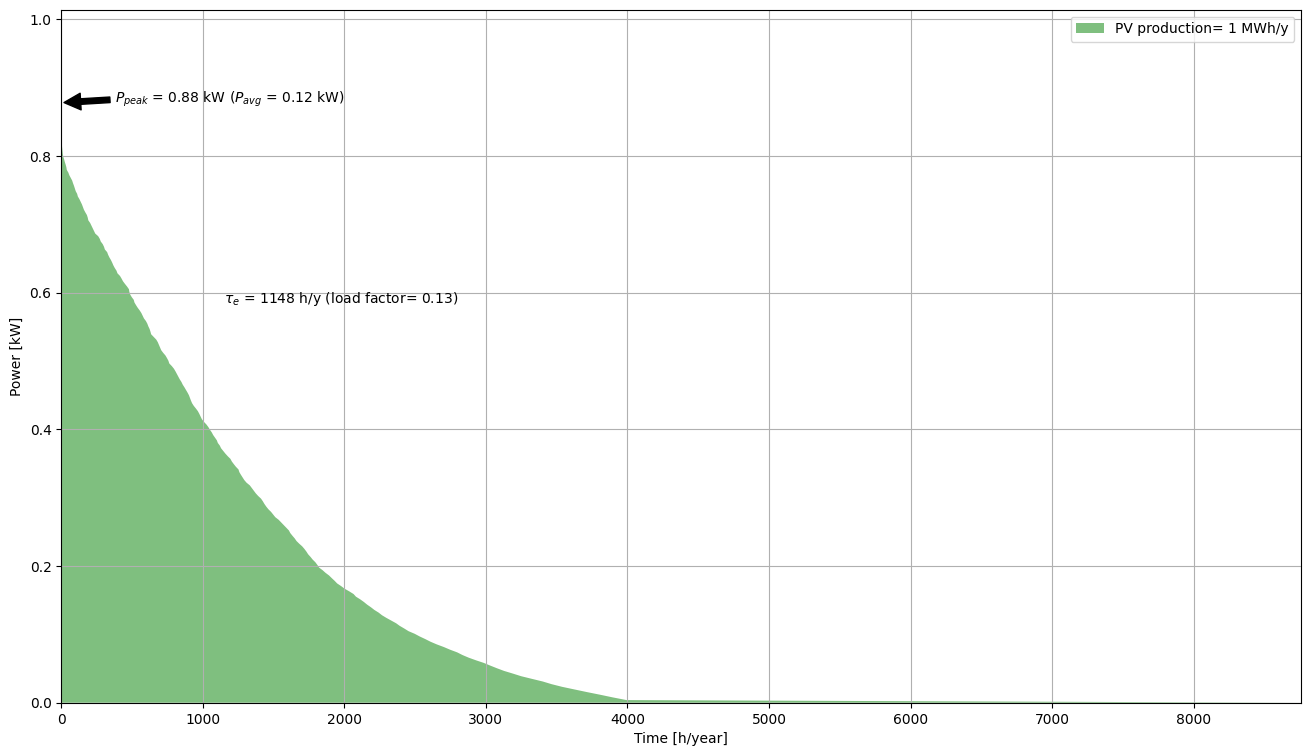

In [22]:
import numpy as np
import math
import matplotlib.pylab as plt
from scipy import interpolate
from scipy.optimize import fsolve
from IPython.display import display

%matplotlib inline

def GetProfile(filename):
    dpm = [0,31,28,31,30,31,30,31,31,30,31,30]
    ConsoData = open(filename, 'r')
    Buf = ConsoData.readlines()
    n_lines = len(Buf)
    dt = 1.
    n_step = int(24. / dt)
    n_days = 365
    E_house = np.zeros((n_days,n_step), dtype=float)
    date = np.arange(0,n_days)
    time = np.arange(0,24,dt)

    j = 0 # index for the time
    k = 0 # index for the day
    for i in range(n_lines-1):
        (tmp1, tmp2, Buf1) = Buf[i+1].split(',')
        (yy, mm, dd) = tmp1.split('-')
        (h, m, s) = tmp2.split(':')
        t_float = round(float(h)+float(m)/60.,0)
        j, = np.where(time==t_float)
        k = int(dd)-1+np.sum(dpm[0:int(mm)])
        E_house[k,j[0]] = float(Buf1)
    return time, date, E_house

def GetPVProduction(filename, fulloutput=False):
    dpm = [31,28,31,30,31,30,31,31,30,31,30]
    PVGISData = open(filename, 'r')
    Buf = PVGISData.readlines()
    n_lines = len(Buf)-11-11
    dt = 1.
    n_step = int(24. / dt)
    n_days = int(n_lines / n_step)
    P_pv = np.zeros((n_days,n_step), dtype=float)
    T2m = np.zeros((n_days,n_step), dtype=float)
    WS10m = np.zeros((n_days,n_step), dtype=float)
    date = np.arange(0,n_days)
    time = np.arange(0,24,dt)
    j = 0 # index for the time
    k = 0 # index for the day
    Ppeak = float(Buf[8].split(':')[1])
    for i in range(n_lines-11):
        (Buf1, Buf2, Buf3, Buf4, Buf5, Buf6, Buf7) = Buf[i+11].split(',')
        (tmp1, tmp2) = Buf1.split(':')
        yy = tmp1[0:4]
        mm = tmp1[4:6]
        dd = tmp1[6:8]
        h = tmp2[0:2]
        m = tmp2[2:4]
        t_float = float(h)
        j, = np.where(time==t_float)
        k = int(dd)-1+int(np.sum(dpm[0:int(mm)-1]))
        P_pv[k,j[0]] = float(Buf2)/1000.
        T2m[k,j[0]] = float(Buf5)
        WS10m[k,j[0]] = float(Buf6)

    if fulloutput: return time, date, P_pv/Ppeak, T2m, WS10m
    else: return time, date, P_pv/Ppeak

def LoadDurationCurve(t, d, P, color='blue', name='Power', steps=250):
    m = len(d) # the number of lines in P
    n = len(t) # the number of columns in P
    dt = 24. / n
    
    Psteps = np.linspace(0., np.amax(P)*1.1, num=steps) # the power considered in the cumulative sum
    Tau = np.zeros(steps, dtype=float) # the number of operating hours
    Pflat = np.reshape(P, m*n)
    for i in range(steps, 0, -1): Tau[i-1] = (np.ma.masked_greater_equal(Pflat, Psteps[i-1])).mask.sum()*dt
    E_tot = 0
    for i in range(m): E_tot += np.trapz(P[i,:], t)
        
    P_max = np.amax(Pflat)
    tau_e = E_tot / P_max
    load_factor = tau_e / (m*24.)
    P_avg = P_max * load_factor

    fig, ax = plt.subplots(figsize=(16, 9))
    plt.close(fig)
    ax.fill_between(Tau, Psteps, 0., facecolor=color, alpha=.5, interpolate=True, label=u'%s= %.0f MWh/y' %(name,E_tot/1000.))
    ax.set_xlim(0, m*24.)
    ax.set_ylim(bottom=0)
    ax.set_ylabel('Power [kW]')
    ax.set_xlabel('Time [h/year]')
    ax.grid(True)
    ax.annotate(r'$P_{peak}$ = %.2f kW ($P_{avg}$ = %.2f kW)' %(P_max, P_avg), xy=(0, P_max), xytext=(tau_e/3, P_max),
            arrowprops=dict(facecolor='black', shrink=0.05))
    ax.text(tau_e, P_max/3*2, r'$\tau_e$ = %.0f h/y (load factor= %.2f)' %(tau_e, load_factor))
    ax.legend()
    return fig
    
(t, date, P_el_total) = GetProfile('Groupe1.csv')  
LDC_elec = LoadDurationCurve(t, date, P_el_total, color='blue', name='Electricity Demand', steps=250)
display(LDC_elec)
LDC_elec.savefig('./LoadDurationCurveElec.png', dpi=300, transparent=True)

(t, date, tau_pv) = GetPVProduction('SolarData.csv')
LDC_PV = LoadDurationCurve(t, date, tau_pv, color='green', name='PV production', steps=250)
display(LDC_PV)
LDC_PV.savefig('./LoadDurationCurvePV.png', dpi=300, transparent=True)

In [23]:
##########################################################
##
## Function calculating the energy balance between the 
## demand P_dmd and the non flexible production P_nf
##
#########################################################

def EnergyBalance(time, date, P_dmd, P_nf, E_sto_rated, Eff_sto):

    m = len(date) # the number of lines in P
    n = len(time) # the number of columns in P
    dt = 24. / n
    
    P_default = np.zeros((m,n), dtype=float)   # the additionnal power required to meet the demand
    P_excess = np.zeros((m,n), dtype=float)    # the power exceeding the demand
    P_st = np.zeros((m,n), dtype=float)       # the power supplied by a storage device
    P_ch = np.zeros((m,n), dtype=float)        # the power supplied to a storage device
    P_grid = np.zeros((m,n), dtype=float)      # the power imported from the grid
    P_export = np.zeros((m,n), dtype=float)    # the power exported to the grid

    E_sto = E_sto_rated / 2.
    E_sto_init = E_sto + 1.

    while E_sto < E_sto_init:
        E_sto_init=E_sto
        E_dmd = 0.
        E_nf = 0.
        E_grid = 0.
        E_export = 0.
        E_st = 0.
        E_ch = 0.
        for i in range(m):
            for j in range(n):
                P_excess[i,j] = max(P_nf[i,j]-P_dmd[i,j], 0.)
                P_ch[i,j] = min(P_excess[i,j], (E_sto_rated-E_sto)/dt) # Excess power is stored if sufficient storage capacity
                E_sto += P_ch[i,j]*dt  # Increment the energy stored 
                P_export[i,j] = P_excess[i,j] - P_ch[i,j] # Energy that cannot be stored is exported

                P_default[i,j] = max(P_dmd[i,j]-P_nf[i,j], 0.)
                P_st[i,j] = min(P_default[i,j], E_sto*Eff_sto/dt) # If enough energy in available, default power is supplied from storage
                E_sto -= P_st[i,j]*dt/Eff_sto # update energy storage
                P_grid[i,j] = P_default[i,j] - P_st[i,j] # Import required energy from grid
                if (E_sto < 0.): E_sto =0. # rounding errors might generate negative energy storage...

            E_dmd += np.trapz(P_dmd[i,:], time)
            E_nf += np.trapz(P_nf[i,:], time)
            E_grid += np.trapz(P_grid[i,:], time)
            E_export += np.trapz(P_export[i,:], time)
            E_st += np.trapz(P_st[i,:], time)
            E_ch += np.trapz(P_ch[i,:], time)
        
    # If energy remains in storage, this energy is exported to the grid
    E_ch -= (E_sto-E_sto_init)
    E_export += (E_sto-E_sto_init)
    return E_dmd, E_st, E_grid, E_nf, E_ch, E_export

def TSC(P_rated, tau_e, c_0, u_fix, N, d, c_f, eta, u_var):
    psi = d / (1.-(1.+d)**(-N))
    return (c_0 * psi + u_fix)*P_rated + (c_f/eta + u_var)*P_rated*tau_e

In [24]:
P_pv_vec = np.linspace(0, 1e4, num=10)
E_sto_vec = np.linspace(0, 1e5, num=10)
COE = np.zeros((10,10), dtype=float)

def SystemDesign(P_pv_inst, E_sto_rated):
    SPE = 0.
    BPE = 150.
    Eff_sto = 0.9
    
    (E_dmd, E_st, E_grid, E_nf, E_ch, E_export) = EnergyBalance(t, date, P_el_total, tau_pv*P_pv_inst, E_sto_rated, Eff_sto)
    grid_cost = TSC(6000., E_grid/6000., 0., 0., 1., 0.01, BPE/1000., 1.00, 0.)
    PV_cost = TSC(P_pv_inst, np.sum(tau_pv), 1000., 10., 15., 0.03, 0, 0.15, 0.)
    export_cost = TSC(6000., E_export/6000., 0., 0., 1., 0.01, -SPE/1000., 1.00, 0.)
    storage_cost = TSC(E_sto_rated, 0., 50., 10., 15., 0.03, 0, 0.15, 0.)
    TotalCost = PV_cost + grid_cost + export_cost + storage_cost
    return TotalCost/E_dmd*1000.

for j in range(10):
    for i in range(10):
        COE[i,j] = SystemDesign(P_pv_vec[i], E_sto_vec[j])
        
idx = np.where(COE==COE.min())
print(P_pv_vec[idx[0][0]], E_sto_vec[idx[1][0]], COE[idx[0][0], idx[1][0]])

1111.111111111111 0.0 145.32749933219895
